## Importing packages

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import os
import cv2

print(tf.__version__)

2.5.0


In [3]:
os.chdir(r'C:\Users\User\OneDrive\Desktop\proj_mvs')            # changing working directory

In [4]:
os.getcwd()

'C:\\Users\\User\\OneDrive\\Desktop\\proj_mvs'

### Creating training data
#### (combining images in two folders together)

In [5]:
img_size=224
training_data = []
def create_training_data(class1,class2):
    Classes=[class1 ,class2 ]
    for category in Classes:
        path = os.path.join('train/', category)
        class_num = Classes.index(category) #0,1(index)
        for img in os.listdir(path):
            img_array= cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
            backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
            new_array= cv2.resize(backtorgb,(img_size,img_size))
            training_data.append([new_array,class_num])
    
    print(len(training_data))                 

In [6]:
create_training_data('Open1','Closed1')

2125


### mixing the images in training data

In [7]:
import random

random.shuffle(training_data)

### creating a duplicate training data, shuffling it and converting it to a dataframe

In [8]:
td = []
def create_td(class1,class2):
    Classes=[class1 ,class2 ]
    for category in Classes:
        path = os.path.join('train/', category)
        class_num = Classes.index(category) #0,1(index)
        for img in os.listdir(path):
            td.append([img,class_num])
    
    print(len(td))  

In [9]:
create_td('Open1','Closed1')

2125


In [10]:
random.shuffle(td)

In [11]:
df = pd.DataFrame(td,
                 columns=['image','y'])
df.head()

,image,y
0,s0001_00537_0_0_0_0_1_01.png,1
1,s0001_01416_0_1_0_2_0_01.png,1
2,s0001_01236_0_1_0_0_0_01.png,1
3,s0001_01528_0_1_0_0_0_01.png,1
4,s0001_02669_0_1_1_2_0_01.png,0


In [12]:
df.y = df.y.astype(str)

In [13]:
df.head()

,image,y
0,s0001_00537_0_0_0_0_1_01.png,1
1,s0001_01416_0_1_0_2_0_01.png,1
2,s0001_01236_0_1_0_0_0_01.png,1
3,s0001_01528_0_1_0_0_0_01.png,1
4,s0001_02669_0_1_1_2_0_01.png,0


### creating train and validation set and converting them ito dataframe

In [14]:
training_set, validation_set = train_test_split(td, random_state = 0, test_size = 0.2)

In [15]:
tr_df = pd.DataFrame(training_set,
                    columns=['image','y']) # training list into dataframe

In [16]:
tr_df.head()

,image,y
0,s0001_01990_0_0_1_0_0_01.png,0
1,s0001_02039_0_0_1_0_0_01.png,0
2,s0001_00944_0_1_0_2_0_01.png,1
3,s0001_02461_0_0_1_0_0_01.png,0
4,s0001_01964_0_0_1_0_0_01.png,0


In [17]:
tr_df.to_csv("train_set1.csv",index=0)

In [18]:
training_set_1 = pd.read_csv("train_set1.csv")

In [19]:
training_set_1.y = training_set_1.y.astype(str)

In [20]:
len(training_set_1)

1700

In [21]:
vd_df = pd.DataFrame(validation_set,
                    columns=['image','y'])
vd_df.head()

,image,y
0,s0001_02954_0_1_1_2_0_01.png,0
1,s0001_00948_0_1_0_2_0_01.png,1
2,s0001_02965_0_1_1_2_0_01.png,0
3,s0001_02678_0_1_1_2_0_01.png,0
4,s0001_01999_0_0_1_0_0_01.png,0


In [22]:
vd_df.to_csv("validation_set1.csv",index=0)

In [23]:
validation_set_1 = pd.read_csv("validation_set1.csv")

In [24]:
validation_set_1.y = validation_set_1.y.astype(str)

In [25]:
len(validation_set)

425

### preprocessing the image data

In [26]:
train_dataGen = ImageDataGenerator(rescale = 1./255,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)




In [27]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
train_generator = train_dataGen.flow_from_dataframe(dataframe = training_set_1,
                                                    directory="train/new/",
                                                    x_col="image", 
                                                    y_col="y", 
                                                    class_mode="binary", 
                                                    target_size=(160,160), batch_size=32)

validation_generator = validation_datagen.flow_from_dataframe(dataframe= validation_set_1,
                                                              directory="train/new/", 
                                                              x_col="image", 
                                                              y_col="y", 
                                                              class_mode="binary", 
                                                              target_size=(160,160), batch_size=32)

Found 1700 validated image filenames belonging to 2 classes.
Found 425 validated image filenames belonging to 2 classes.


In [29]:
image_size = 160
IMG_SHAPE = (image_size, image_size, 3)


### Create the base model from the pre-trained model MobileNet V2

In [30]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [31]:
base_model.trainable = False

### adding three extra layers

In [32]:
model = tf.keras.Sequential([
                          base_model,
                          keras.layers.GlobalAveragePooling2D(),
                          keras.layers.Dense(1, activation='sigmoid')])

### compiling the new model

In [33]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### training the new model

In [34]:
new_model = tf.keras.models.load_model('my_model_Drowsiness_2.h5')

### Trying prediction on closed and open images

In [40]:
img_array = cv2.imread("train/open/_214.jpg",cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb , (160,160) )

X_input = np.array(new_array).reshape(1, 160,160,3)

X_input.shape

(1, 160, 160, 3)

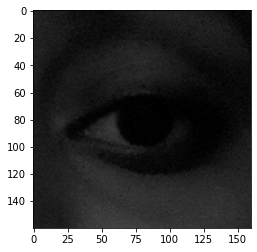

In [41]:
plt.imshow(new_array)

In [42]:
X_input =X_input/160.0

In [43]:
prediction = new_model.predict(X_input)

In [44]:
prediction

array([[0.00235039]], dtype=float32)

In [60]:
img_array = cv2.imread("train/Closed/_666.jpg",cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb , (160,160) )

X_input = np.array(new_array).reshape(1, 160,160,3)

X_input.shape

(1, 160, 160, 3)

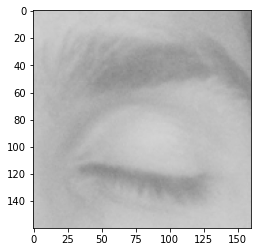

In [61]:
plt.imshow(new_array)

In [62]:
X_input =X_input/160.0

In [63]:
prediction = new_model.predict(X_input)

In [64]:
prediction

array([[0.9896492]], dtype=float32)

### trying prediction on an image with face

In [65]:
img = cv2.imread("happy_girl.jpg")

In [66]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [67]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

### Cropping the eyes

In [68]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_eye.xml')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
     #print (faceCascade.empty())
eyes = eye_cascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in eyes:
    roi_gray = gray[y:y+h , x:x+w ]
    roi_color = img[y:y+h , x:x+w ]
    eyess = eye_cascade.detectMultiScale(roi_gray)
    if len(eyess) == 0:
        print("closed")
    else:
        for (ex,ey,ew,eh) in eyess:
            eyes_roi = roi_color[ey : ey+eh , ex: ex+ew]
    

closed
closed


In [69]:
eyes_roi.shape

(56, 56, 3)

In [70]:
final_image = cv2.resize(eyes_roi, (160,160))
final_image = np.expand_dims(final_image,axis=0)
final_image = final_image/255.0

In [71]:
img

array([[[200, 202, 202],
        [200, 202, 202],
        [200, 202, 202],
        ...,
        [208, 208, 208],
        [208, 208, 208],
        [208, 208, 208]],

       [[200, 202, 202],
        [200, 202, 202],
        [200, 202, 202],
        ...,
        [208, 208, 208],
        [208, 208, 208],
        [208, 208, 208]],

       [[200, 202, 202],
        [200, 202, 202],
        [200, 202, 202],
        ...,
        [208, 208, 208],
        [208, 208, 208],
        [208, 208, 208]],

       ...,

       [[178, 180, 180],
        [178, 180, 180],
        [178, 180, 180],
        ...,
        [189, 191, 192],
        [188, 190, 191],
        [188, 190, 191]],

       [[178, 180, 180],
        [178, 180, 180],
        [178, 180, 180],
        ...,
        [189, 191, 192],
        [188, 190, 191],
        [188, 190, 191]],

       [[178, 180, 180],
        [178, 180, 180],
        [178, 180, 180],
        ...,
        [188, 190, 191],
        [188, 190, 191],
        [188, 190, 191]]

In [72]:
final_image.shape

(1, 160, 160, 3)

In [73]:
new_model.predict(final_image)

array([[0.9991889]], dtype=float32)

# Real time implementation

In [ ]:
import winsound
frequency = 2500
duration = 30000
import numpy as np
import cv2
path = "haarcascade_frontalface_default.xml"
faceCasade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(1)
# check if the webcam is opened correctly
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("cannot open webcam")
counter = 0
while True:
    ret,frame = cap.read()
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY )
    #print faceCascade.empty())
    eyes = eye_cascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in eyes:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame,(x, y), (x+w, y+h), (0,255,0), 2)
        eyess = eye_cascade.detectMultiScale(roi_gray)
        if len(eyess) == 0:
            print("eyes not detected")
        
        else:
            for(ex,ey,ew,eh) in eyess:
                eyes_roi = roi_color[ey: ey+eh, ex: ex+ew]
                
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    print(faceCascade.empty())
    faces = faceCascade.detectMultiScale(gray,1.1,4)
    
    #draw rectangle around faces
    for(x, y, w, h) in faces:
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)
        
    font = cv2.FONT_HERSHEY_SIMPLEX  
    
    #use putText() method for
    #inserting text on video
    
    final_image = cv2.resize(eyes_roi, (160,160))
    final_image = np.expand_dims(final_image,axis=0)
    final_image = final_image/255.0
    
    predictions = new_model.predict(final_image)
    if (predictions<0.2):
        status = "Open Eyes"
        cv2.putText(frame,
               status,
               (150,150),
               font, 3,
               (0, 255, 0),
               2,
               cv2.LINE_4)
        x1,y1,w1,h1 = 0,0,175,75
        # draw black background rectangle
        
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #add text
        
        cv2.putText(frame, 'Active', (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
    else:
        counter = counter + 1
        status = "Closed Eyes"
        cv2.putText(frame,
               status,
               (150,150),
               font, 3,
               (0, 0, 255),
               2,
               cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255), 2)
        if counter>5:
            
            x1,y1,w1,h1 = 0,0,175,75
            # draw black background rectangle
            cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
            #add text
            cv2.putText(frame, 'Sleep Alert !!', (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,225), 2)
            winsound.Beep(frequency, duration)
            counter = 0
    
    
    
    
    cv2.imshow('Drowsiness Detection', frame)
    

    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

eyes not detected
False
eyes not detected
eyes not detected
False
eyes not detected
False
eyes not detected
False
False
False
